In [4]:
import sys
import os
import urllib3
import json
import numpy as np
import datetime
from dateutil import tz
import time
import random
import pickle
import pytz
import copy
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [5]:
#request weather by cities
#all cities are CST/CDT
cities = {"Witchita Falls": (33.9137, -98.4934), 
          "Mineral Wells": (32.8085, -98.1128), 
          "Paris": (33.6609, -95.5555), 
          "Dallas": (32.7767, -96.7970), 
          "Fort Worth": (32.7555, -97.3308), 
          "Tyler": (32.3513, -95.3011),  
          "Waco": (31.5493, -97.1467), 
          "San Angelo": (31.4638, -100.4370), 
          "Abilene": (32.4487, -99.7331), 
          "Midland": (31.9973, -102.0779), 
          "Wink": (31.7512, -103.1599), 
          "Junction": (30.4894, -99.7720), 
          "Austin": (30.2672, -97.7431), 
          "Houston": (29.7604, -95.3698), 
          "Galveston": (29.3013, -94.7977), 
          "Victoria": (28.8053, -97.0036), 
          "Corpus Christi": (27.8006, -97.39640), 
          "Laredo": (27.5306, -99.4803),
          "San Antonio": (29.4241, -98.4936)}

cdt_starts = [datetime.datetime(year=2010, month=3, day=14, hour=2, minute=0, second=0),
             datetime.datetime(year=2011, month=3, day=13, hour=2, minute=0, second=0),
             datetime.datetime(year=2012, month=3, day=11, hour=2, minute=0, second=0),
             datetime.datetime(year=2013, month=3, day=10, hour=2, minute=0, second=0),
             datetime.datetime(year=2014, month=3, day=9, hour=2, minute=0, second=0),
             datetime.datetime(year=2015, month=3, day=8, hour=2, minute=0, second=0),
             datetime.datetime(year=2016, month=3, day=13, hour=2, minute=0, second=0),
             datetime.datetime(year=2017, month=3, day=12, hour=2, minute=0, second=0),
             datetime.datetime(year=2018, month=3, day=11, hour=2, minute=0, second=0)]

cst_starts = [datetime.datetime(year=2010, month=11, day=7, hour=2, minute=0, second=0),
             datetime.datetime(year=2011, month=11, day=6, hour=2, minute=0, second=0),
             datetime.datetime(year=2012, month=11, day=4, hour=2, minute=0, second=0),
             datetime.datetime(year=2013, month=11, day=3, hour=2, minute=0, second=0),
             datetime.datetime(year=2014, month=11, day=2, hour=2, minute=0, second=0),
             datetime.datetime(year=2015, month=11, day=1, hour=2, minute=0, second=0),
             datetime.datetime(year=2016, month=11, day=6, hour=2, minute=0, second=0),
             datetime.datetime(year=2017, month=11, day=5, hour=2, minute=0, second=0),
             datetime.datetime(year=2018, month=11, day=4, hour=2, minute=0, second=0)]
              


In [6]:
#startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0) #naive local time PST
startdate = 1262325600
curr = startdate
#enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)
enddate = 1514786400

alldays = []

while curr <= enddate:
    alldays.append(curr) #need to shift for daylight savings
    curr += 24 * 3600

In [7]:
alldays[-1] + 24*3600

1514872800

In [8]:
#startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0) #naive local time PST
startdate = 1262325600
curr = startdate
#enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)
enddate = 1514786400

allhours = []

while curr <= enddate:
    allhours.append(curr) #need to shift for daylight savings
    curr += 3600

In [9]:
1446361200 in allhours

True

In [12]:
#helper functions
#files names are grid_longitude,latitude.json
tz = pytz.timezone('America/Chicago')

time_keys_to_norm = ['sunriseTime', 'sunsetTime', 'temperatureHighTime', 'temperatureLowTime', 'temperatureMinTime', 'temperatureMaxTime', 'apparentTemperatureMinTime', 'apparentTemperatureMaxTime', 'precipIntensityMaxTime', 'time', 'apparentTemperatureLowTime', 'apparentTemperatureHighTime']
values_to_norm = ['temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed', 'windBearing', 'visibility', 'temperatureHigh', 'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow', 'pressure', 'temperatureMin', 'temperatureMax', 'apparentTemperatureMax', 'apparentTemperatureMin', 'precipIntensity', 'precipIntensityMax', 'precipAccumulation']
str_to_norm = {'icon': ['clear-day', 'clear-night', 'cloudy', 'fog', 'partly-cloudy-day', 'partly-cloudy-night', 'rain', 'snow', 'wind', 'none'], 'precipType': ['snow', 'rain', 'none']}
icons = ['clear-day', 'clear-night', 'cloudy', 'fog', 'partly-cloudy-day', 'partly-cloudy-night', 'rain', 'snow', 'wind', 'none']
precips = ['snow', 'rain', 'none']
values_no_norm = ['cloudCover', 'moonPhase', 'precipProbability']
values_to_drop = ['latitude', 'longitude', 'summary']

def parse_filename(fnamestr):
    token = fnamestr.split("_")[1]
    token_ = token[:-5] #break off .json extension
    tokens = token_.split(",")
    #return (lat, long)
    return((float(tokens[1]), float(tokens[0])))

def norm_to_time_of_day(unixtime):
    if np.isnan(unixtime):
        val = np.nan
    elif unixtime < 0.0: #for missing times
        val = -1.0
    else:
        dt = datetime.datetime.fromtimestamp(unixtime, tz)
        h = dt.hour * 3600 + dt.minute * 60 + dt.second 
        val = h/86400
    return(val)

def str_to_norm_func(strin, key):
    if type(strin) == str:
        vals = sorted(list(str_to_norm[key]))
        i = vals.index(strin)
        denom = len(vals) - 1
        out = i/denom
    else:
        out = np.nan
    return(out)

def itermean(oldmean, newval, num):
    if np.isnan(newval):
        out = oldmean
    else:
        out = oldmean + ((newval - oldmean)/float(num))
    return(out)

def itervar(oldvar, oldmean, newval, num):
    if np.isnan(newval):
        out = oldvar
    else:
        n = float(num)
        out = ((n - 1)*oldvar + (newval - oldmean)*(newval - oldmean))/n
    return(out)

In [10]:
#global variables

weatherdir = "/home/chase/projects/peakload/data/weather/ercot/major_cities/"
outdir = weatherdir + "array_formatted/"
years = range(2010,2018)
tkeys = ['currently', 'daily', 'hourly', 'latitude', 'longitude']

In [13]:
#want to scan ahead to get all keys and use map for missing data points
#dont' need k + i + lk, just want lk's for each hour
lkeys = {'daily': set(), 'hourly': set()}

grid_locs = set()

for year in years:
    days = os.listdir(weatherdir + str(year))
    for day in days:
        wms = os.listdir(weatherdir + str(year) + "/" + day)
        for fname in wms:
            loc = parse_filename(fname)
            sloc = str(loc[0]) + "," + str(loc[1])
            grid_locs.add(sloc)
            with open(weatherdir + str(year) + "/" + day + "/" + fname, 'r') as d:
                data = json.load(d)
            for k in tkeys:
                if k == 'daily' or k == 'hourly':
                    curr = data[k]['data'] #list of dicts
                    for di in range(len(curr)):
                        d = curr[di]
                        for lk in d:
                            lkeys[k].add(lk)


In [11]:
grid_locs = sorted(list(grid_locs))
with open(outdir + "grid_locs.pck", 'wb') as f:
    pickle.dump(grid_locs, f)
    
with open(outdir + "city_locs.pck", 'wb') as f:
    pickle.dump(cities, f)

In [18]:
grid_locs = sorted(list(grid_locs))
print(grid_locs)

['27.5306,-99.4803', '27.8006,-97.3964', '28.8053,-97.0036', '29.3013,-94.7977', '29.4241,-98.4936', '29.7604,-95.3698', '30.2672,-97.7431', '30.4894,-99.772', '31.4638,-100.437', '31.5493,-97.1467', '31.7512,-103.1599', '31.9973,-102.0779', '32.3513,-95.3011', '32.4487,-99.7331', '32.7555,-97.3308', '32.7767,-96.797', '32.8085,-98.1128', '33.6609,-95.5555', '33.9137,-98.4934']


In [15]:
#features to output data arrays for
#features_hourly = ['precipProbability', 'temperature', 'apparentTemperature', 'humidity', 'pressure', 'visibility', 'windSpeed']

features_hourly = ['temperature', 'precipProbability', 'apparentTemperature', 'humidity', 'pressure', 'windSpeed', 'visibility', 'windBearing']

In [19]:
for feature in features_hourly:
    min_val = 10000.0
    max_val = -10000.0
    print(feature)
    missing_vals = 0
    hourly_data_temp = {}

    for h in allhours:
        hourly_data_temp[h] = {}
        for l in grid_locs:
            hourly_data_temp[h][l] = 0.0

    for year in years:
        print(year)
        days = os.listdir(weatherdir + str(year))
        for day in days:
            wms = os.listdir(weatherdir + str(year) + "/" + day)
            for fname in wms:
                loc = parse_filename(fname)
                sloc = str(loc[0]) + "," + str(loc[1])
                loc_i = grid_locs.index(sloc)
                with open(weatherdir + str(year) + "/" + day + "/" + fname, 'r') as d:
                    data = json.load(d)

                for k in tkeys:
                    if k == 'hourly':
                        curr = data[k]['data'] #list of dicts
                        for point in curr:
                            try:
                                hourly_data_temp[point['time']][sloc] = float(point[feature])  #rough normalization ahead of time
                                if float(point[feature]) > max_val:
                                    max_val = float(point[feature])
                                if float(point[feature]) < min_val:
                                    min_val = float(point[feature])
                            except:
                                missing_vals += 1
                                hourly_data_temp[point['time']][sloc] = 0.0
    
    temps_array = np.zeros((len(grid_locs), len(allhours)))
    for t in allhours:
        j = allhours.index(t)
        for l in grid_locs:
            i = grid_locs.index(l)
            temps_array[i,j] = hourly_data_temp[t][l]
            
    temps_array_out = (temps_array - min_val)/(max_val - min_val)
            
    np.savetxt("/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/" + feature + "_array.csv", temps_array_out, delimiter=",")
    print("missing values: " + str(missing_vals))
    print(np.max(temps_array_out), np.min(temps_array_out))

temperature
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 0
1.0 -0.04790588235294117
precipProbability
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 3
1.0 0.0
apparentTemperature
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 0
1.0 0.0
humidity
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 9
1.0 -0.030927835051546393
pressure
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 22
1.0 -15.93411916680121
windSpeed
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 391
1.0 0.0
visibility
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 9
1.0 -0.003009027081243731
windBearing
2010
2011
2012
2013
2014
2015
2016
2017
missing values: 924
1.0 0.0


In [22]:
point

{'apparentTemperature': 41.05,
 'cloudCover': 0.16,
 'dewPoint': 19.6,
 'humidity': 0.33,
 'icon': 'clear-day',
 'precipType': 'rain',
 'pressure': 1027.12,
 'summary': 'Clear',
 'temperature': 46.89,
 'time': 1293044400,
 'visibility': 10,
 'windBearing': 24,
 'windSpeed': 13.56}

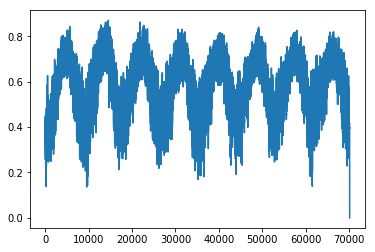

In [63]:
plt.plot(np.mean(temps_array,axis=0))
plt.show()

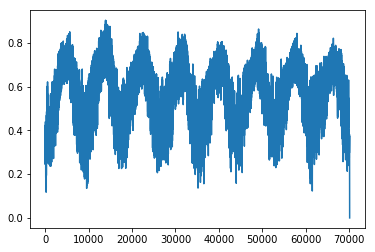

In [57]:
times = sorted(list(hourly_data_temp.keys()))
sloc = grid_locs[12]
temps = []

for t in times:
    temps.append(hourly_data_temp[t][sloc])
    
plt.plot(temps)
plt.show()

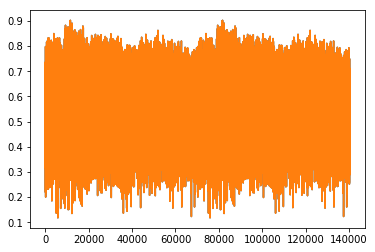

In [60]:
plt.plot(temp_lists[grid_locs.index(sloc)])
plt.show()

In [58]:
with open("/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/temps_only.pck", 'wb') as d:
    pickle.dump(temp_lists, d)

In [ ]:
#full

In [12]:
#for each hour, create a vector with an element for each key in lkeys
#assign an index for each element in lkeys

lkeymap = {}
daily = 0
hourly = 0
for tk in lkeys:
    lkeymap[tk] = {}
    for lk in lkeys[tk]:
        if lk == 'latitude' or lk == 'longitude' or lk == 'summary':
            pass
        elif tk == 'daily':
            lkeymap[tk][lk] = daily
            daily += 1
        elif tk == 'hourly':
            lkeymap[tk][lk] = hourly
            hourly += 1

print(lkeymap)

{'daily': {'temperatureMinTime': 0, 'windBearing': 1, 'humidity': 2, 'pressure': 3, 'temperatureLowTime': 4, 'icon': 5, 'apparentTemperatureMin': 6, 'precipAccumulation': 7, 'apparentTemperatureLow': 8, 'sunriseTime': 9, 'temperatureHigh': 10, 'moonPhase': 11, 'visibility': 12, 'precipIntensityMaxTime': 13, 'temperatureLow': 14, 'sunsetTime': 15, 'temperatureMax': 16, 'apparentTemperatureMaxTime': 17, 'cloudCover': 18, 'precipProbability': 19, 'precipType': 20, 'windSpeed': 21, 'apparentTemperatureMinTime': 22, 'dewPoint': 23, 'time': 24, 'apparentTemperatureHighTime': 25, 'temperatureHighTime': 26, 'precipIntensity': 27, 'temperatureMaxTime': 28, 'apparentTemperatureLowTime': 29, 'temperatureMin': 30, 'precipIntensityMax': 31, 'apparentTemperatureHigh': 32, 'apparentTemperatureMax': 33}, 'hourly': {'precipIntensity': 0, 'precipProbability': 1, 'visibility': 2, 'precipType': 3, 'windSpeed': 4, 'windBearing': 5, 'apparentTemperature': 6, 'humidity': 7, 'pressure': 8, 'dewPoint': 9, 'ico

In [13]:
#save lkeymap to 
with open(outdir + "data_keys.pck", 'wb') as d:
    pickle.dump(lkeymap, d)

In [14]:
hourly_data = {}
daily_data = {}

for h in allhours:
    hourly_data[h] = {}
    for l in grid_locs:
        hourly_data[h][l] = {}

for d in alldays:
    daily_data[d] = {}
    for l in grid_locs:
        daily_data[d][l] = {}

In [16]:
#daily[time] is coming back PST midnight, data is coming back correct to timezone

for year in years:
    days = os.listdir(weatherdir + str(year))
    for day in days:
        wms = os.listdir(weatherdir + str(year) + "/" + day)
        for fname in wms:
            loc = parse_filename(fname)
            sloc = str(loc[0]) + "," + str(loc[1])
            loc_i = grid_locs.index(sloc)
            with open(weatherdir + str(year) + "/" + day + "/" + fname, 'r') as d:
                data = json.load(d)

            for k in tkeys:
                if k == 'hourly':
                    curr = data[k]['data'] #list of dicts
                    
                    #need to just pull out time stamps from data and start/stop accordingly
                    for i in range(len(curr)):
                        time_int = curr[i]['time']
                        if time_int not in hourly_data.keys():
                            print("hourly", time_int)
                            #print(curr)
                            pass
                        else:
                            for key in curr[i]:
                                hourly_data[time_int][sloc][key] = curr[i][key]
                        if 'precipType' not in curr[i].keys():
                            hourly_data[time_int][sloc]['precipType'] = 'none'
                        if 'precipAccumulation' not in curr[i].keys():
                            hourly_data[time_int][sloc]['precipAccumulation'] = 0.0
                                
                elif k == 'daily':
                    d = data[k]['data'][0]
                    time_int = int(day)
                    if time_int not in daily_data.keys():
                        #print('daily', time_int)
                        daily_data[time_int] = {}
                        for l in grid_locs:
                            daily_data[time_int][l] = {}
                    else:
                        for key in d:
                            daily_data[time_int][sloc][key] = d[key]
                    
                    if 'precipType' not in d.keys():
                        daily_data[time_int][sloc]['precipType'] = 'none'
                    if 'precipIntensityMaxTime' not in d.keys():
                        daily_data[time_int][sloc]['precipIntensityMaxTime'] = -1.0
                    if 'precipAccumulation' not in d.keys():
                        daily_data[time_int][sloc]['precipAccumulation'] = 0.0
                    if 'cloudCover' not in d.keys():
                        daily_data[time_int][sloc]['cloudCover'] = 0.0
        
#all_days_hourly_arrays[day] = allhours_outvector_gridlocs
with open(outdir + "daily_weather_dict.pck", 'wb') as f:
    pickle.dump(daily_data, f)
        
#all_days_hourly_arrays[day] = allhours_outvector_gridlocs
with open(outdir + "hourly_weather_dict.pck", 'wb') as f:
    pickle.dump(hourly_data, f)

In [18]:
#get mins and maxes to normalize data
minmaxs = {}
for hour in hourly_data.keys():
    for loc in hourly_data[hour].keys():
        curr = hourly_data[hour][loc]
        for k in values_to_norm:
            if k not in minmaxs.keys() and k in lkeymap['hourly'].keys():
                if k not in curr.keys():
                    minmaxs[k] = {'min': 1000.0, 'max': -1000.0}
                else:
                    minmaxs[k] = {'min': curr[k], 'max': curr[k]}
            elif k in lkeymap['hourly'].keys():
                if k not in curr.keys():
                    pass
                else:
                    if curr[k] < minmaxs[k]['min']:
                        minmaxs[k]['min'] = curr[k]
                    if curr[k] > minmaxs[k]['max']:
                        minmaxs[k]['max'] = curr[k]
                        
for day in daily_data.keys():
    for loc in daily_data[day].keys():
        curr = daily_data[day][loc]
        for k in values_to_norm:
            if k not in minmaxs.keys() and k in lkeymap['daily'].keys():
                if k not in curr.keys():
                    minmaxs[k] = {'min': 1000.0, 'max': -1000.0}
                else:
                    minmaxs[k] = {'min': curr[k], 'max': curr[k]}
            elif k in lkeymap['daily'].keys():
                if k not in curr.keys():
                    pass
                else:
                    if curr[k] < minmaxs[k]['min']:
                        minmaxs[k]['min'] = curr[k]
                    if curr[k] > minmaxs[k]['max']:
                        minmaxs[k]['max'] = curr[k]

In [19]:
minmaxs

{'apparentTemperature': {'max': 117.45, 'min': -9.37},
 'apparentTemperatureHigh': {'max': 117.45, 'min': 2.19},
 'apparentTemperatureLow': {'max': 99.45, 'min': -9.37},
 'apparentTemperatureMax': {'max': 117.45, 'min': 6.33},
 'apparentTemperatureMin': {'max': 98.05, 'min': -9.37},
 'dewPoint': {'max': 82.24, 'min': -13.06},
 'humidity': {'max': 1, 'min': 0.03},
 'precipAccumulation': {'max': 5.177, 'min': 0.0},
 'precipIntensity': {'max': 4.0215, 'min': 0},
 'precipIntensityMax': {'max': 4.0215, 'min': 0},
 'pressure': {'max': 1048.73, 'min': 986.8},
 'temperature': {'max': 111.34, 'min': 5.09},
 'temperatureHigh': {'max': 111.34, 'min': 16.6},
 'temperatureLow': {'max': 87.67, 'min': 5.09},
 'temperatureMax': {'max': 111.34, 'min': 17.06},
 'temperatureMin': {'max': 87.67, 'min': 5.09},
 'visibility': {'max': 10, 'min': 0.03},
 'windBearing': {'max': 359, 'min': 0},
 'windSpeed': {'max': 43.7, 'min': 0}}

In [24]:
#I want a dict that has a local timestamp as the start time, and an array of locations x features, only work with hourly weather data
A = np.empty((len(grid_locs), len(lkeymap['hourly'])), dtype=np.float32)
A.fill(np.nan)

hourly_array_data = {}

for hour in allhours:
    hourly_array_data[hour] = np.copy(A)
    for i in range(len(grid_locs)):
        sloc = grid_locs[i]
        tokens = sloc.split(",")
        lat = float(tokens[0])
        lon = float(tokens[1])
        data = hourly_data[hour][grid_locs[i]]
        for metric in lkeymap['hourly'].keys():
            j = lkeymap['hourly'][metric]
            if metric in values_to_drop:
                pass
            elif metric not in data.keys():
                hourly_array_data[hour][i,j] = np.nan
            elif metric in values_to_norm:
                hourly_array_data[hour][i,j] = (data[metric] - minmaxs[metric]['min'])/(minmaxs[metric]['max'] - minmaxs[metric]['min'])
            elif metric in str_to_norm:
                hourly_array_data[hour][i,j] = str_to_norm_func(data[metric], metric)
            elif metric in time_keys_to_norm:
                hourly_array_data[hour][i,j] = norm_to_time_of_day(data[metric])
            elif metric in values_no_norm:
                hourly_array_data[hour][i,j] = data[metric]
            else:
                print(metric)


In [26]:
hourkeys = list(hourly_array_data.keys())
nans = np.zeros((hourly_array_data[hourkeys[0]].shape[1],))
total = 0
for t in hourkeys:
    for l in range(hourly_array_data[t].shape[0]):
        total +=1
        for j in range(hourly_array_data[t].shape[1]):
            if np.isnan(hourly_array_data[t][l,j]):
                nans[j] += 1

In [27]:
nans

array([2.2000e+01, 2.2000e+01, 2.8000e+01, 1.9000e+01, 4.1000e+02,
       9.4300e+02, 1.9000e+01, 2.8000e+01, 4.1000e+01, 2.8000e+01,
       1.9000e+01, 1.9000e+01, 1.9000e+01, 6.9896e+04, 1.9000e+01])

In [28]:
percs = nans/total
for i in range(len(list((percs)))):
    if percs[i] > 0.06:
        for item in lkeymap['hourly']:
            if i == lkeymap['hourly'][item]:
                print(item)

In [29]:
percs

array([1.65109261e-05, 1.65109261e-05, 2.10139060e-05, 1.42594362e-05,
       3.07703623e-04, 7.07718333e-04, 1.42594362e-05, 2.10139060e-05,
       3.07703623e-05, 2.10139060e-05, 1.42594362e-05, 1.42594362e-05,
       1.42594362e-05, 5.24567132e-02, 1.42594362e-05])

In [30]:
#I want a dict that has a local timestamp as the start time, and an array of locations x features, only work with hourly weather data
A = np.empty((len(grid_locs), len(lkeymap['daily'])), dtype=np.float32)
A.fill(np.nan)

daily_array_data = {}

for hour in daily_data.keys():
    #get day
    dt = datetime.datetime.utcfromtimestamp(hour)
    ndt = datetime.datetime(year=dt.year, month=dt.month, day=dt.day, hour=0, minute=0, second=0)
    daily_array_data[ndt] = np.copy(A)
    for i in range(len(grid_locs)):
        sloc = grid_locs[i]
        tokens = sloc.split(",")
        lat = float(tokens[0])
        lon = float(tokens[1])
        data = daily_data[hour][grid_locs[i]]
        for metric in lkeymap['daily'].keys():
            j = lkeymap['daily'][metric]
            if metric in values_to_drop:
                pass
            elif metric not in data.keys():
                daily_array_data[ndt][i,j] = np.nan
            elif metric in values_to_norm:
                daily_array_data[ndt][i,j] = (data[metric] - minmaxs[metric]['min'])/(minmaxs[metric]['max'] - minmaxs[metric]['min'])
            elif metric in str_to_norm:
                daily_array_data[ndt][i,j] = str_to_norm_func(data[metric], metric)
            elif metric in time_keys_to_norm:
                daily_array_data[ndt][i,j] = norm_to_time_of_day(data[metric])
            elif metric in values_no_norm:
                daily_array_data[ndt][i,j] = data[metric]
            else:
                print(metric)

In [31]:
#evaluate where all the nan's are coming from
daykeys = list(daily_array_data.keys())
nans = np.zeros((daily_array_data[daykeys[0]].shape[1],))
total = 0
for t in daykeys:
    for l in range(daily_array_data[t].shape[0]):
        total+=1
        for j in range(daily_array_data[t].shape[1]):
            if np.isnan(daily_array_data[t][l,j]):
                nans[j] += 1
    

In [33]:
percs = nans/total
for i in range(len(list((percs)))):
    if percs[i] > 0.06:
        for item in lkeymap['daily']:
            if i == lkeymap['daily'][item]:
                print(item)

In [34]:
with open("/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/hourly_data_normalized.pck", 'wb') as f:
    pickle.dump(hourly_array_data, f)
    
with open("/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/daily_data_normalized.pck", 'wb') as f:
    pickle.dump(daily_array_data, f)

In [9]:
#still need to do engineered features
#max temp and apparent temp observed so far
#min temp and apparent temp observed so far
#precipitation accum so far
#avg high and apparent high over last two weeks
#avg low and apparent low over last two weeks
#avg humidity over last two weeks
#avg cloud cover over last two weeks
#get rid of nans

In [8]:
#read in data
weatherdir = "/home/chase/projects/peakload/data/weather/ercot/major_cities/"
outdir = weatherdir + "array_formatted/"
years = range(2010,2018)

with open(outdir + "hourly_data_normalized.pck", 'rb') as f:
    hourly_array_data = pickle.load(f)
    
with open(outdir + "daily_data_normalized.pck", 'rb') as f:
    daily_array_data = pickle.load(f)
    
with open(outdir + "grid_locs.pck", 'rb') as f:
    grid_locs = pickle.load(f)
    
with open(outdir + "data_keys.pck", 'rb') as d:
    lkeymap = pickle.load(d)

In [12]:
avg_two_week = ['apparentTemperatureHigh', 'apparentTemperatureMax', 'apparentTemperatureMin', 'apparentTemperatureLow', 'cloudCover', 'humidity', 'temperatureHigh', 'temperatureMax', 'temperatureMin', 'temperatureLow', 'windSpeed', 'apparentTemperature', 'temperature']
max_over_bill = avg_two_week
min_over_bill = avg_two_week
accum_over_bill = ['precipAccumulation']

num_features = len(avg_two_week + max_over_bill + min_over_bill + accum_over_bill)
feature_sets = {'avg_two_week': avg_two_week, 'max_over_bill': max_over_bill, 'min_over_bill': min_over_bill, 'accum_over_bill': accum_over_bill}

daily_features = avg_two_week + accum_over_bill
hourly_features = ['temperature', 'humidity', 'apparentTemperature', 'windSpeed', 'precipAccumulation']
engineered_feature_map = {'daily': 
                          {'avg_two_week': {}, 
                           'max_over_bill': {}, 
                           'min_over_bill': {}, 
                           'accum_over_bill': {}},
                          'hourly': 
                          {'avg_two_week': {}, 
                           'max_over_bill': {}, 
                           'min_over_bill': {}, 
                           'accum_over_bill': {}} }

dk = 0
for s in feature_sets:
    for metric in feature_sets[s]:
        engineered_feature_map['daily'][s][metric] = dk
        dk += 1
dk -= 1
        
hk = 0
for s in feature_sets:
    for metric in feature_sets[s]:
        if metric in hourly_features:
            engineered_feature_map['hourly'][s][metric] = hk
            hk += 1
hk -= 1            
print(engineered_feature_map)

{'daily': {'avg_two_week': {'apparentTemperatureHigh': 0, 'apparentTemperatureMax': 1, 'apparentTemperatureMin': 2, 'apparentTemperatureLow': 3, 'cloudCover': 4, 'humidity': 5, 'temperatureHigh': 6, 'temperatureMax': 7, 'temperatureMin': 8, 'temperatureLow': 9, 'windSpeed': 10, 'apparentTemperature': 11, 'temperature': 12}, 'max_over_bill': {'apparentTemperatureHigh': 13, 'apparentTemperatureMax': 14, 'apparentTemperatureMin': 15, 'apparentTemperatureLow': 16, 'cloudCover': 17, 'humidity': 18, 'temperatureHigh': 19, 'temperatureMax': 20, 'temperatureMin': 21, 'temperatureLow': 22, 'windSpeed': 23, 'apparentTemperature': 24, 'temperature': 25}, 'min_over_bill': {'apparentTemperatureHigh': 26, 'apparentTemperatureMax': 27, 'apparentTemperatureMin': 28, 'apparentTemperatureLow': 29, 'cloudCover': 30, 'humidity': 31, 'temperatureHigh': 32, 'temperatureMax': 33, 'temperatureMin': 34, 'temperatureLow': 35, 'windSpeed': 36, 'apparentTemperature': 37, 'temperature': 38}, 'accum_over_bill': {'p

In [10]:
hourly_vectorized_data = {}

max_so_far = {}
min_so_far = {}
accum_so_far = {}

for item in max_over_bill:
    max_so_far[item] = -1000.0
for item in min_over_bill:
    min_so_far[item] = 1000.0
for item in accum_over_bill:
    accum_so_far[item] = 0.0
    
    
accums = copy.copy(accum_so_far)
maxs = copy.copy(max_so_far)
mins = copy.copy(min_so_far)

training_hours = sorted(list(hourly_array_data.keys())[:-1])

year = 2010
for t in range(len(training_hours)):
    feature_array = np.zeros((len(grid_locs), hk+1))
    y = datetime.datetime.utcfromtimestamp(training_hours[t]).year
    if y > year:
        accums = copy.copy(accum_so_far)
        maxs = copy.copy(max_so_far)
        mins = copy.copy(min_so_far)
    for j in range(len(grid_locs)):
        for item in lkeymap['hourly']:
            if item in hourly_features:
                if item in avg_two_week:
                    m = hourly_array_data[training_hours[t]][j,lkeymap['hourly'][item]]
                    for h in range(14*24):
                        nval = hourly_array_data[training_hours[t-h]][j,lkeymap['hourly'][item]]
                        m = itermean(m, nval, h+1)
                    k = engineered_feature_map['hourly']['avg_two_week'][item]
                    feature_array[j,k] = m   
                if item in max_over_bill:
                    currval = hourly_array_data[training_hours[t]][j,lkeymap['hourly'][item]]
                    if currval > maxs[item]:
                        maxs[item] = currval
                    k = engineered_feature_map['hourly']['max_over_bill'][item]
                    feature_array[j,k] = maxs[item]
                if item in min_over_bill:
                    currval = hourly_array_data[training_hours[t]][j,lkeymap['hourly'][item]]
                    if currval < mins[item]:
                        mins[item] = currval
                    k = engineered_feature_map['hourly']['min_over_bill'][item] 
                    feature_array[j,k] = mins[item]
                if item in accum_over_bill:
                    accums[item] += hourly_array_data[training_hours[t]][j,lkeymap['hourly'][item]]
                    k = engineered_feature_map['hourly']['accum_over_bill'][item] 
                    feature_array[j,k] = accums[item]
    hourly_vectorized_data[training_hours[t]] = np.concatenate((hourly_array_data[training_hours[t]].flatten(), feature_array.flatten()), axis=0)


In [ ]:
with open("/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/hourly_data_feature_vector.pck", 'wb') as f:
    pickle.dump(hourly_vectorized_data, f)

In [15]:
daily_vectorized_data = {}

max_so_far = {}
min_so_far = {}
accum_so_far = {}

for item in max_over_bill:
    max_so_far[item] = -1000.0
for item in min_over_bill:
    min_so_far[item] = 1000.0
for item in accum_over_bill:
    accum_so_far[item] = 0.0
    
accums = copy.copy(accum_so_far)
maxs = copy.copy(max_so_far)
mins = copy.copy(min_so_far)

training_hours = sorted(list(daily_array_data.keys()))

year = 2010
for t in range(len(training_hours)):
    feature_array = np.zeros((len(grid_locs), dk+1))
    y = training_hours[t].year
    if y > year:
        accums = copy.copy(accum_so_far)
        maxs = copy.copy(max_so_far)
        mins = copy.copy(min_so_far)
    for j in range(len(grid_locs)):
        for item in lkeymap['daily']:
            if item in daily_features:
                if item in avg_two_week:
                    m = daily_array_data[training_hours[t]][j,lkeymap['daily'][item]]
                    for h in range(30): #30 day lookback for daily averages
                        nval = daily_array_data[training_hours[t-h]][j,lkeymap['daily'][item]]
                        m = itermean(m, nval, h+1)
                    k = engineered_feature_map['daily']['avg_two_week'][item]
                    feature_array[j,k] = m   
                if item in max_over_bill:
                    currval = daily_array_data[training_hours[t]][j,lkeymap['daily'][item]]
                    if currval > maxs[item]:
                        maxs[item] = currval
                    k = engineered_feature_map['daily']['max_over_bill'][item]
                    feature_array[j,k] = maxs[item]
                if item in min_over_bill:
                    currval = daily_array_data[training_hours[t]][j,lkeymap['daily'][item]]
                    if currval < mins[item]:
                        mins[item] = currval
                    k = engineered_feature_map['daily']['min_over_bill'][item] 
                    feature_array[j,k] = mins[item]
                if item in accum_over_bill:
                    accums[item] += daily_array_data[training_hours[t]][j,lkeymap['daily'][item]]
                    k = engineered_feature_map['daily']['accum_over_bill'][item] 
                    feature_array[j,k] = accums[item]
    daily_vectorized_data[training_hours[t]] = np.concatenate((daily_array_data[training_hours[t]].flatten(), feature_array.flatten()), axis=0)


In [16]:
with open("/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/daily_data_feature_vector.pck", 'wb') as f:
    pickle.dump(daily_vectorized_data, f)

In [17]:
daily_vectorized_data

{datetime.datetime(2010, 1, 1, 0, 0): array([0.33333334, 0.99164343, 0.556701  , ..., 0.        , 0.        ,
        0.03728028]),
 datetime.datetime(2010, 1, 2, 0, 0): array([0.29166666, 0.30919221, 0.71134019, ..., 0.        , 0.        ,
        0.03728028]),
 datetime.datetime(2010, 1, 3, 0, 0): array([0.29166666, 0.1086351 , 0.74226803, ..., 0.        , 0.        ,
        0.04500676]),
 datetime.datetime(2010, 1, 4, 0, 0): array([0.95833331, 0.1253482 , 0.63917524, ..., 0.        , 0.        ,
        0.07726482]),
 datetime.datetime(2010, 1, 5, 0, 0): array([0.29166666, 0.36768803, 0.56701028, ..., 0.        , 0.        ,
        0.08112807]),
 datetime.datetime(2010, 1, 6, 0, 0): array([0.75      , 0.38997215, 0.73195875, ..., 0.        , 0.        ,
        0.08112807]),
 datetime.datetime(2010, 1, 7, 0, 0): array([0.75      , 0.01949861, 0.73195875, ..., 0.        , 0.        ,
        0.08305969]),
 datetime.datetime(2010, 1, 8, 0, 0): array([0.95833331, 0.99164343, 0.34020